In [505]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx
import ipywidgets as widgets
import collections

from IPython.display import display
from IPython.display import clear_output

In [506]:
class Spremnik:
    q = np.array([], dtype=int)
        
    def front(self):
        return self.q[0]
    
    def pop(self):
        val = self.q[0]
        self.q = np.delete(self.q, 0)
        return val
    
    def size(self):
        return self.q.size
    
    def empty(self):
        return self.q.size == 0
    
    def flip(self):
        self.q = np.flip(self.q)
        return self
    
    # vraca string, treba mi za print(class) poziv
    def __str__(self):
        return np.array2string(self.q, separator=', ')
    
class Queue(Spremnik):
    def push(self, val):
        self.q = np.insert(self.q, len(self.q), val)
        
class Stack(Spremnik):
    def push(self, val):
        self.q = np.insert(self.q, 0, val)

In [507]:
def dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor):
    q = Stack()
    trenutni_cvor = ciljni_cvor
    
    while trenutni_cvor != pocetni_cvor:
        q.push(trenutni_cvor)
        trenutni_cvor = roditelj_cvora[trenutni_cvor]
        
    q.push(trenutni_cvor)
    
    return q

In [508]:
def BFS(G, pocetni_cvor, ciljni_cvor):
    q = Queue()
    q.push(pocetni_cvor)
    
    posjeceni_cvorovi = np.zeros(len(G), dtype=int)
    posjeceni_cvorovi[pocetni_cvor] = True
    
    roditelj_cvora = np.zeros(len(G), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor;

    put_obilaska_stabla = Stack()
    
    df = pd.DataFrame([], columns=['susjedi', 'trenutni cvor', 'red', 'lista_posjecenih'])
    df = df.append(pd.Series(['-', '-', '[' + str(pocetni_cvor) + ']', '-'], index=df.columns ), ignore_index=True)
    
    while q.empty() == False:
        trenutni_cvor = q.pop()
        put_obilaska_stabla.push(trenutni_cvor)

        red = pd.Series([str(sorted(G[trenutni_cvor])), str(trenutni_cvor), str(q), str(put_obilaska_stabla)], index=df.columns) 
        df = df.append(red, ignore_index=True)
        
        if trenutni_cvor == ciljni_cvor:
            return { 'put' : dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor), 
                     'put_obilaska' : put_obilaska_stabla.flip(),
                     'tablica' : df
                   }
        
        for susjedni_cvor in sorted(G[trenutni_cvor]):
            if posjeceni_cvorovi[susjedni_cvor] == False:
                posjeceni_cvorovi[susjedni_cvor] = True
                roditelj_cvora[susjedni_cvor] = trenutni_cvor
                q.push(susjedni_cvor)

In [517]:
def DFS(G, pocetni_cvor, ciljni_cvor):
    s = Stack()
    s.push(pocetni_cvor)
    
    posjeceni_cvorovi = np.zeros(len(G), dtype=int)
    
    roditelj_cvora = np.zeros(len(G), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor;
    
    put_obilaska_stabla = Stack()
    
    #dodajemo podatke u tablicu
    df = pd.DataFrame([], columns=['susjedi', 'trenutni cvor', 'stog', 'lista_posjecenih'])
    df = df.append(pd.Series(['-', '-', '[' + str(pocetni_cvor) + ']', '-'], index=df.columns ), ignore_index=True)
    
    while s.empty() == False:
        trenutni_cvor = s.pop()
        put_obilaska_stabla.push(trenutni_cvor)
        
        #dodajemo podatke u tablicu            
        red = pd.Series([str(sorted(G[trenutni_cvor])), str(trenutni_cvor), str(s), str(put_obilaska_stabla)], index=df.columns) 
        df = df.append(red, ignore_index=True)
        
        if trenutni_cvor == ciljni_cvor:
            return {'put' : dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor), 
                    'put_obilaska' : put_obilaska_stabla.flip(),
                    'tablica' : df
                   }
        
        posjeceni_cvorovi[trenutni_cvor] = True
        for susjedni_cvor in sorted(G[trenutni_cvor], reverse = True):
             if posjeceni_cvorovi[susjedni_cvor] == False:
                roditelj_cvora[susjedni_cvor] = trenutni_cvor
                s.push(susjedni_cvor)

In [510]:
broj_cvorova = 9
pocetni_cvor = 1
ciljni_cvor = 5

,susjedi,trenutni cvor,stog,lista_posjecenih
0,-,-,[1],-
1,"[0, 2, 6]",1,[],[1]
2,"[1, 8]",0,"[2, 6]","[0, 1]"
3,"[0, 7]",8,"[2, 6]","[8, 0, 1]"
4,"[4, 6, 8]",7,"[2, 6]","[7, 8, 0, 1]"
5,"[3, 5, 7]",4,"[6, 2, 6]","[4, 7, 8, 0, 1]"
6,"[2, 4]",3,"[5, 6, 2, 6]","[3, 4, 7, 8, 0, 1]"
7,"[1, 3]",2,"[5, 6, 2, 6]","[2, 3, 4, 7, 8, 0, 1]"
8,"[4, 6]",5,"[6, 2, 6]","[5, 2, 3, 4, 7, 8, 0, 1]"


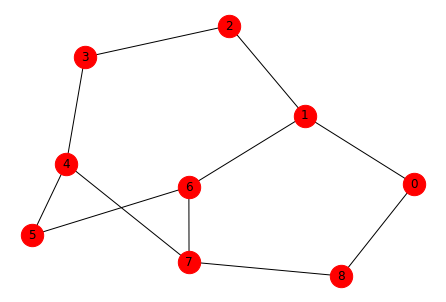

In [515]:
# s ovim generiram random povezan graf
G = nx.generators.random_graphs.newman_watts_strogatz_graph(broj_cvorova, 2, 0.35, np.random.randint(1000))

nx.draw_kamada_kawai(G, node_size=500, with_labels=True, node_color='red')

DFS(G, pocetni_cvor, ciljni_cvor)['tablica']

In [512]:
def ispisi_output():
    for index, ime_algoritma in enumerate(imena_algoritama):
        node_colors[ime_algoritma] = [node_colors_map[ime_algoritma][node] for node in G.nodes()]
        
        print()
        
        plt.subplot(1, len(imena_algoritama), index + 1)   
        nx.draw_kamada_kawai(G, node_size=300, with_labels=True, node_color=node_colors[ime_algoritma])
    
    clear_output(wait=True)
    
    display(HBox, output)

def promjeni_boju_cvora(put_1, put_2, colors_map, boja):
    if put_1.empty() == False:
            put_2.push(put_1.pop())
            colors_map[put_2.front()] = boja;
    
def slijedeci_clicked(b):
    for ime_algoritma in imena_algoritama:
        promjeni_boju_cvora(put[ime_algoritma], prijedeni_put[ime_algoritma], 
                            node_colors_map[ime_algoritma], 'yellow'
                            )

    ispisi_output()
        
def prethodni_clicked(b):
    for ime_algoritma in imena_algoritama:
        promjeni_boju_cvora(prijedeni_put[ime_algoritma], put[ime_algoritma],
                            node_colors_map[ime_algoritma], 'red'
                            )
        
    ispisi_output()

Output()

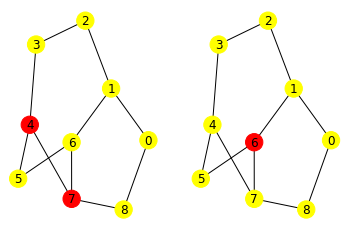

In [516]:
# definiramo gumbe
slijedeci = widgets.Button(description=">")
prethodni = widgets.Button(description="<")
output = widgets.Output()
HBox = widgets.HBox([prethodni, slijedeci])

slijedeci.on_click(slijedeci_clicked)
prethodni.on_click(prethodni_clicked)

# za dodat novi algoritam samo dodati ime i u varijablu put dodati pripadnu funkciju
imena_algoritama = ['BFS', 'DFS']
vrsta = 'put_obilaska'

prijedeni_put = { ime_algoritma : Stack() for ime_algoritma in imena_algoritama }
put = { 'BFS' : BFS(G, pocetni_cvor, ciljni_cvor)[vrsta], 
        'DFS' : DFS(G, pocetni_cvor, ciljni_cvor)[vrsta]
      }

# dictionary s bojama za svaki nod
node_colors_map = { ime_algoritma : { i : 'red' for i in range(len(G)) } for ime_algoritma in imena_algoritama }

# niz odgovarajucih boja
node_colors = { ime_algoritma : [node_colors_map[ime_algoritma][node] for node in G.nodes()] 
               for ime_algoritma in imena_algoritama 
              }

ispisi_output()